## Load modules and data

In [44]:
## Load## Load modules and data modules
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

#Base
from os import path
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import scipy.stats as st
from tqdm.notebook import trange, tqdm
import time
from statsmodels.stats.multitest import fdrcorrection

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)


#V1DD
from experiment.v1dd_em_client import V1DDEMClient
from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession
from stimulus_analysis.stimulus_analysis import StimulusAnalysis
from stimulus_analysis.drifting_gratings import DriftingGratings
from stimulus_analysis.natural_scenes import NaturalScenes
from stimulus_analysis.natural_movie import NaturalMovie
from stimulus_analysis import fit_utils
import analysis_tools as at
from stimulus_analysis.timing_utils import find_nearest

#Network 
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import greedy_modularity_communities, naive_greedy_modularity_communities
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/home/dwyrick/data/v1dd_in_vivo_new_segmentation" # Local on Essun for golden mouse
client = V1DDClient(base_folder)



In [3]:
##===== Load session from golden mouse =====##
goldenmouse_id = 409828; col = 1; vol = 3; plane = 3
sess = client.load_ophys_session(mouse=goldenmouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

data_list = []; ts_list = []; roiID_list = []
for plane in range(1,7):
    #Get dff traces
    dff_full, ts_full = sess.get_traces(plane, trace_type='events')
    # deconv_dff_full, ts_full = sess.get_traces(plane, trace_type='events')

    #Only take valid cells
    mask = sess.is_roi_valid(plane)
    indy = np.where(mask)[0]

    #Subsample
    dff = dff_full[indy]; ts = ts_full
    data_list.append(dff); ts_list.append(ts)
    roi_ids = np.array(sess.get_rois(plane))
    roi_ids_valid = roi_ids[indy]
    roiID_list.append(roi_ids_valid)


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


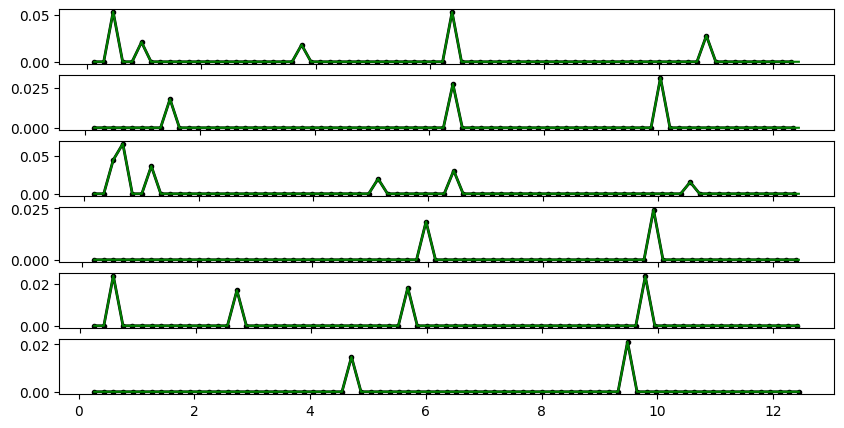

In [4]:
## Interpolate all planes to the same time
ts_array = np.array(ts_list)
ts_mean = np.mean(ts_array,axis=0)
ts_all = np.sort(np.concatenate(ts_list))
data_list_interp = []

fig, axes = plt.subplots(6,1,figsize=(10,5))

plotslice = slice(0,75)
for ii, (data, ts) in enumerate(zip(data_list,ts_list)):
    ax = axes[ii]

    
    f = interpolate.interp1d(ts,data, axis=1,kind='linear',bounds_error=False)
    data_interp = f(ts_all)
    data_list_interp.append(data_interp)

    
    ax.plot(ts[plotslice],data[0,plotslice],'.-',color='k',lw=2)
    # ax.plot(ts_mean[plotslice],data_interp[0,plotslice],'.-',color='g',lw=2)
    ax.plot(ts_all[slice(0,75*6)],data_interp[0,slice(0,75*6)],'-',color='g')


## Calculate pairwise correlations between neurons
separated by running and rest

In [5]:
#Get stimulus times for spontaneous
stim_table, stim_meta = sess.get_stimulus_table("spontaneous")
iStart = find_nearest(ts_all, stim_table['start'][0])
iEnd = find_nearest(ts_all, stim_table['end'][0])

In [6]:
data_array = np.concatenate(data_list_interp,axis=0)
data_spont = data_array[:,slice(iStart,iEnd)]
ts_spont = ts_all[slice(iStart,iEnd)]


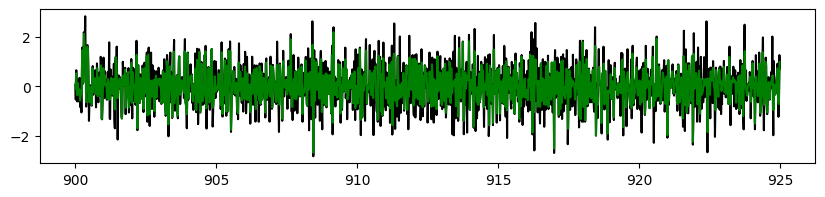

In [7]:
running_speed, timestamps = sess.get_running_speed()

tstart = 900; tend = 925

indy_spont = np.where((timestamps > np.min(ts_spont)) & (timestamps < np.max(ts_spont)))[0]
#Interpolate running to same timestamps
fig, ax = plt.subplots(figsize=(10,2))

tmp_t = timestamps[indy_spont]; tmp_r = running_speed[indy_spont]
indy = np.where((tmp_t > tstart) & (tmp_t < tend))[0]
plt.plot(tmp_t[indy],tmp_r[indy],'-k')

f = interpolate.interp1d(timestamps,running_speed,kind='linear',bounds_error=False)
rs_interp = f(ts_spont)

# scipy.signal.decimate(running_speed,2)
indy = np.where((ts_spont > tstart) & (ts_spont < tend))[0]
plt.plot(ts_spont[indy],rs_interp[indy],'-',color='g')

In [9]:

def calculate_running_mask(speed_vec, fr = 37, run_thresh=3):
    #Break spontaneous period into 1 second windows
    combine_factor = fr 
    nBins_runvec = speed_vec.shape[0]
    nBins_filt = np.floor(nBins_runvec/combine_factor).astype(int)

    #Find bins where the animal is running/stationary
    running_mask_fullres =  np.array(speed_vec > run_thresh,dtype=int)
    running_mask_filtres = np.zeros((nBins_filt),dtype=np.int8)

    for iBool in range(nBins_filt):
        iStart = iBool*combine_factor; iEnd = (iBool+1)*combine_factor
        fBins_animal_running = np.sum(running_mask_fullres[iStart:iEnd])/combine_factor

        #Is the animal running, at rest, or some combination of both in this second
        if fBins_animal_running >= 0.7:
            running_mask_filtres[iBool] = 1
        elif fBins_animal_running < 0.3:
            running_mask_filtres[iBool] = 0
        else:
            running_mask_filtres[iBool] = -1

    running_mask = np.array(speed_vec > run_thresh,dtype=int)
    return running_mask


speed_vec = rs_interp
running_mask = calculate_running_mask(speed_vec)
print('{:.1f}% of spontaneous period animal spent running'.format(np.sum(running_mask)*100/len(running_mask)))

23.5% of spontaneous period animal spent running


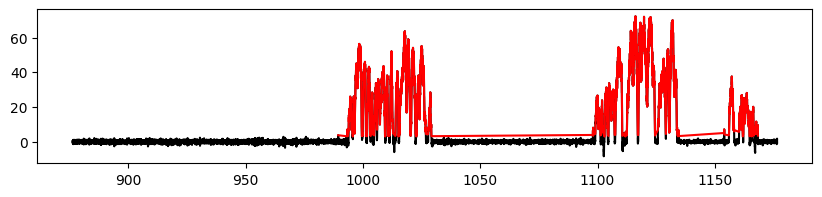

In [10]:
fig, ax = plt.subplots(figsize=(10,2))
plt.plot(ts_spont,speed_vec,'-k')
mask = np.array(running_mask,dtype=bool)
plt.plot(ts_spont[mask],speed_vec[mask],'-r')

In [30]:
def correlation_FC(X,transform='fisher'):
    
    N, T = X.shape
            
    #Loop over each pair and calculate the correlation between signals i and j
    correlation_mat  = np.zeros((N,N))*np.nan
    for i in range(N):
        for j in range(i,N):
            if i == j:
                continue
            indy = np.where((~np.isnan(X[i])) & (~np.isnan(X[j])))[0]
            cc = np.corrcoef(X[i,indy],X[j,indy])[0,1]
            # import pdb; pdb.set_trace()
            correlation_mat[i,j] = cc
            correlation_mat[j,i] = cc
            
#     #Apply transformation   
#     if transform == 'fisher':
#         correlation_mat = np.arctanh(correlation_mat)
        
    return correlation_mat

##===== Calculate correlation & shuffle distribution ======##
def calculate_correlation(data_array, speed_vec = None, subtract_mean = False, nShuffles = 100,shuffle = False):
    N, T = data_array.shape
    running_mask = calculate_running_mask(speed_vec)

    FC = np.zeros((2,N,N))
    if shuffle:
        FC_shf = np.zeros((2,nShuffles,N,N))

    for iR, rstr in enumerate(['Rest','Running']):
        indy = np.where(running_mask == iR)[0]

        if len(indy) == 0:
            continue
        X = data_array[:,indy]

        if subtract_mean:
            X = X - np.mean(X,axis=0).reshape(1,-1)
            
        # processes.append(p.apply_async(DE.correlation_FC, args=(X,)))
        FC[iR]  = correlation_FC(X)

        # if shuffle:
        #     X_orig = X.copy()
        #     FC_shf = np.zeros((nShuffles,N,N))

        #     #Calculate shuffles
        #     for iShf in trange(nShuffles):
        #         X_shf = np.apply_along_axis(np.random.permutation, 1, X_orig)
        #         FC_shf[iShf] = correlation_FC(X_shf)


        #     #Rank correlations to shuffle
        #     pval_uncorrected = 1-2*np.abs(np.array([[st.percentileofscore(FC_shf[:,i,j],FC_shf[i,j],kind='strict') for j in range(N)] for i in range(N)])/100 - .5)
                
        #     mask, pval_corrected = fdrcorrection(pval_uncorrected.ravel())
        #     pval_corrected = pval_corrected.reshape((N,N))
        #     pval_corrected[np.diag_indices(N)] = 0
    
    if shuffle:
        FC, FC_shf
    else:
        FC

In [31]:
N, T = data_array.shape
FC = np.zeros((2,N,N))

indy = np.where(running_mask == 0)[0]
X = data_array[:,indy]

FC[0] = correlation_FC(X)

In [35]:
indy = np.where(running_mask == 1)[0]
X = data_array[:,indy]

FC[1] = correlation_FC(X)

In [40]:
DF_SAVE_DIR = r"/home/dwyrick/Git/v1dd_surround_suppression/dataframes"

np.save(path.join(DF_SAVE_DIR,f'correlation_matrices_m{goldenmouse_id}_{col}{vol}.npy'),FC)

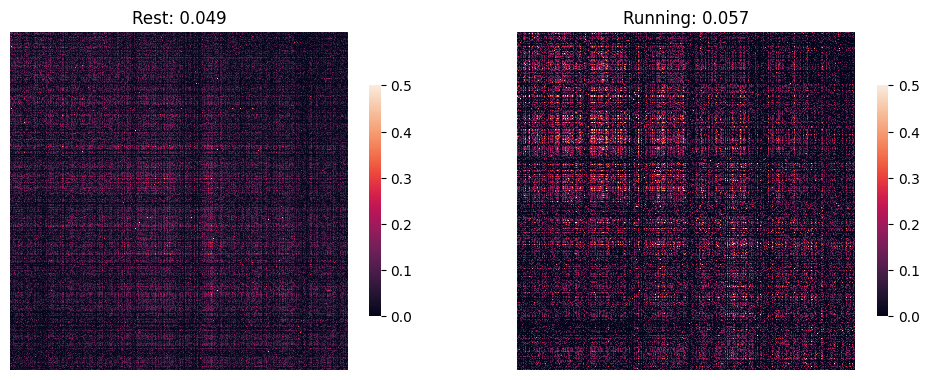

In [51]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

for iR, rstr in enumerate(['Rest','Running']):
    sns.heatmap(FC[iR],ax=axes[iR],cbar=True,square=True,cbar_kws={'shrink':0.5},vmin=0,vmax=0.5,label=rstr)
    axes[iR].axis('off')
    axes[iR].set_title(f'{rstr}: {np.nanmean(FC[iR].ravel()):.3f}')
    # sns.histplot(FC[iR].ravel(),ax=axes[iR],color=cc[iR])


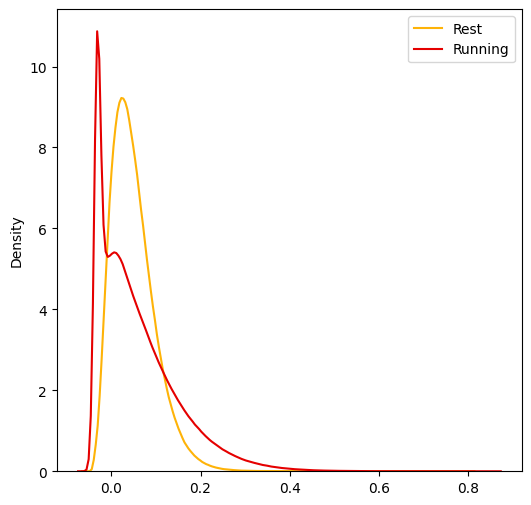

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
for iR, rstr in enumerate(['Rest','Running']):
    sns.kdeplot(FC[iR].ravel(),color=cc[iR],label=rstr)
ax.legend()